In [ ]:
# GENYZ TEAM
# Aleta Edna Jessalyn 
# Angelina Wahyuni 
# Keisya Andretta
# Infall Syafalni

# reusing the nmos and pmos primitives from gLayout

In [1]:
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file,path,scale = 1):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'out.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'out.gds'))
  display_gds(os.path.join(path,'out.gds'),path,scale)

In [2]:
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

In [3]:
nmos_kwargs = {
    "with_tie": True,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

pmos_kwargs = {
    "with_tie": True,
    "dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 1,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": True
}

In [4]:
tg_switch_config={
        "pdk": gf180, # pdk to use
        "placement" : "vertical", # the two fets can be placed either vertically or horizontally
        "width": (2,2), # width of the input fet and feedback fet respectively.
        "length": (0.5,0.5), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (2,2), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult":1, # thickness of the sd metal layer.
}
top_level = Component(name="tg_switch")
pdk=tg_switch_config["pdk"]
pdk.activate()

width=tg_switch_config["width"]
length=tg_switch_config["length"]
fingers=tg_switch_config["fingers"]
multipliers=tg_switch_config["multipliers"]

dummy_1=tg_switch_config["dummy_1"]
dummy_2=tg_switch_config["dummy_2"]
tie_layers1=tg_switch_config["tie_layers1"]
tie_layers2=tg_switch_config["tie_layers2"]
sd_rmult=tg_switch_config["sd_rmult"]

2025-11-05 06:45:23.634 | INFO     | gdsfactory.pdk:activate:337 - 'gf180' PDK is now active


/headless/conda-env/miniconda3/envs/GLdev/lib/python3.10/site-packages/gdsfactory/show.py:40: UserWarning: Unnamed cells, 2 in 'tg_switch'
  gdspath = component.write_gds(
2025-11-05 06:45:29.118 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


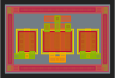

In [5]:
fet_P = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **pmos_kwargs )
nmos_kwargs["with_dnwell"] = False
fet_N = nmos(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, **nmos_kwargs)
fet_P_ref = top_level << fet_P
fet_N_ref = top_level << fet_N

fet_P_ref.name = "Fet_P"
fet_N_ref.name = "Fet_N"

#let's take a look at our current state of layout
## To see in Klayout via Klive
top_level.show()
display_component(top_level, scale = 1,path="../")
## If you want to save the gds file at this stage
#primary_gds = top_level.write_gds("before_placement.gds")

In [6]:
placement=tg_switch_config["placement"]
ref_dimensions = evaluate_bbox(fet_N)

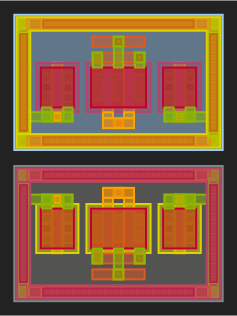

2025-11-05 06:45:30.678 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


In [7]:
if placement == "vertical":
#    display_component(top_level, scale = 2,path="../../")
    fet_N_ref.mirror_y()
    fet_N_ref.movey(fet_P_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-0.5)
elif placement == "vertical_inv":
#    display_component(top_level, scale = 2,path="../../")
    fet_P_ref.mirror_y()
    fet_P_ref.movey(fet_N_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-0.5)
elif placement == "horizontal":
#    display_component(top_level, scale = 2,path="../../")
    fet_N_ref.movex(fet_P_ref.xmax + ref_dimensions[0]/2 + pdk.util_max_metal_seperation()+1)
else:
        raise ValueError("Placement must be either 'vertical', 'vertical _inv', or 'horizontal'")
    
# let's see how our block looks after placement
display_component(top_level, scale = 2,path="../")
## To see in Klayout via Klive
top_level.show()

2025-11-05 06:45:31.169 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


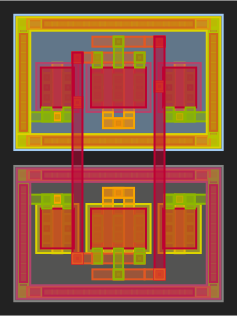

In [8]:
viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.

#via for input and output
drain_P_via = top_level << viam2m3
source_P_via = top_level << viam2m3

if placement == "vertical":
    drain_P_via.move(fet_P_ref.ports["multiplier_0_source_W"].center).movex(-0.75).movey(fet_P_ref.ports["gate_W"].center[1] * 1.1)
    source_P_via.move(fet_P_ref.ports["multiplier_0_drain_E"].center).movex(0.75).movey(fet_P_ref.ports["gate_W"].center[1] * 1.1)
    top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_source_W"], fet_N_ref.ports["multiplier_0_source_W"])
    top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
elif placement == "vertical_inv":
    drain_P_via.move(fet_N_ref.ports["multiplier_0_source_W"].center).movex(-0.75).movey(fet_N_ref.ports["gate_W"].center[1] * 1.1)
    source_P_via.move(fet_N_ref.ports["multiplier_0_drain_E"].center).movex(0.75).movey(fet_N_ref.ports["gate_W"].center[1] * 1.1)
    top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_source_W"], fet_N_ref.ports["multiplier_0_source_W"])
    top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
elif placement == "horizontal":
    source_P_via.move(fet_P_ref.ports["multiplier_0_source_W"].center).movex(ref_dimensions[0]*0.9)
    drain_P_via.move(fet_P_ref.ports["multiplier_0_drain_E"].center).movex(ref_dimensions[0]*0.15)
    top_level << straight_route(pdk, fet_P_ref.ports["multiplier_0_source_E"], fet_N_ref.ports["multiplier_0_source_W"])
    top_level << straight_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_W"])
else:
        raise ValueError("Placement must be either 'vertical', 'vertical_inv', or 'horizontal'.")

top_level.show()
display_component(top_level, scale = 2,path="../")

In [9]:
top_level.add_ports(fet_P_ref.get_ports_list(), prefix="P_")
top_level.add_ports(fet_N_ref.get_ports_list(), prefix="N_")
top_level.add_ports(drain_P_via.get_ports_list(), prefix="P_drain_")
top_level.add_ports(source_P_via.get_ports_list(), prefix="P_source_")

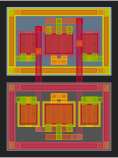

In [10]:
component = component_snap_to_grid(rename_ports_by_orientation(top_level))
    
# Now that our block is complete, let's see how it looks now!!
#component.show()
display_component(component, scale = 1,path="../")
#component.show()
##inv_gds = component.write_gds("inv.gds")

## To see all Ports
#component.pprint_ports()

## To see selected ports
#for s in component.get_ports_list():
#     if len(s.name.split("_")) <4:
#         if set(["P","gate"]).issubset(set(s.name.split("_"))):
#             print(s.name, s.port_type , s.orientation, s.center, s.width, s.layer)

In [11]:
psize=(0.5,0.5)
# list that will contain all port/comp info
move_info = list()
# create labels and append to info list

/headless/conda-env/miniconda3/envs/GLdev/lib/python3.10/site-packages/gdsfactory/show.py:40: UserWarning: Unnamed cells, 1 in 'Unnamed_937658f4'
  gdspath = component.write_gds(
2025-11-05 06:45:33.362 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


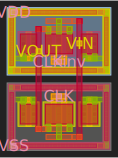

In [12]:
# VSS
vsslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met2_label"))
move_info.append((vsslabel,component.ports["N_tie_N_top_met_W"],None))
#gnd_ref = top_level << gndlabel;

#suply
vddlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met2_label"))
move_info.append((vddlabel,component.ports["P_tie_N_top_met_W"],None))
#sup_ref = top_level << suplabel;


# output
outputlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
outputlabel.add_label(text="VOUT",layer=pdk.get_glayer("met3_label"))
move_info.append((outputlabel,component.ports["P_drain_top_met_N"],None))
#op_ref = top_level << outputlabel;


# input
inputlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
inputlabel.add_label(text="VIN",layer=pdk.get_glayer("met3_label"))
move_info.append((inputlabel,component.ports["P_source_top_met_N"], None))
#ip_ref = top_level << inputlabel;

# CLK
clklabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
clklabel.add_label(text="CLK",layer=pdk.get_glayer("met2_label"))
move_info.append((clklabel,component.ports["N_gate_S"], None))

# CLK_INV
clkinvlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
clkinvlabel.add_label(text="CLKinv",layer=pdk.get_glayer("met2_label"))
move_info.append((clkinvlabel,component.ports["P_gate_N"], None))

for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        top_level.add(compref)
component = top_level.flatten()


component.show()
display_component(top_level, scale =1,path="../")

In [13]:
component.name="tgswitch"
drc_result = gf180.drc_magic(component, component.name)

2025-09-19 13:52:16.867 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmpp2_g_ogw/tgswitch.gds'


using default pdk_root: /usr/bin/miniconda3/share/pdk/
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 528 - Compiled on Wed Jun 18 09:45:25 PM CEST 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmpp2_g_ogw/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "tgswitch".
[INFO]: Loading tgswitch


In [14]:
inv_code_string = """
from glayout import MappedPDK, sky130 , gf180
from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle

from glayout import nmos, pmos
from glayout import via_stack
from glayout import rename_ports_by_orientation
from glayout import tapring

from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist

from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

def add_tgswitch_labels(
    tgswitch_in: Component,
    pdk: MappedPDK,
    ) -> Component:
    
    tgswitch_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    # VSS
    vsslabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met2_label"))
    move_info.append((vsslabel,component.ports["N_tie_N_top_met_W"],None))
    #gnd_ref = top_level << gndlabel;

    #suply
    vddlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met2_label"))
    move_info.append((vddlabel,component.ports["P_tie_N_top_met_W"],None))
    #sup_ref = top_level << suplabel;

    # output
    outputlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputlabel.add_label(text="VOUT",layer=pdk.get_glayer("met3_label"))
    move_info.append((outputlabel,component.ports["P_drain_top_met_N"],None))
    #op_ref = top_level << outputlabel;

    # input
    inputlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputlabel.add_label(text="VIN",layer=pdk.get_glayer("met3_label"))
    move_info.append((inputlabel,component.ports["P_source_top_met_N"], None))
    #ip_ref = top_level << inputlabel;

    # CLK
    clklabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    clklabel.add_label(text="CLK",layer=pdk.get_glayer("met2_label"))
    move_info.append((clklabel,component.ports["N_gate_S"], None))

    # CLK_INV
    clkinvlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    clkinvlabel.add_label(text="CLKinv",layer=pdk.get_glayer("met2_label"))
    move_info.append((clkinvlabel,component.ports["P_gate_N"], None))

    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            tgswitch_in.add(compref)
    
    return tgswitch_in.flatten()
@cell
def tgswitch(
        pdk: MappedPDK,
        placement: str = "vertical",
        width: tuple[float,float] = (12,12),
        length: tuple[float,float] = (0.5,0.5),
        fingers: tuple[int,int] = (5,5),
        multipliers: tuple[int,int] = (1,1),
        dummy_1: tuple[bool,bool] = (True,True),
        dummy_2: tuple[bool,bool] = (True,True),
        tie_layers1: tuple[str,str] = ("met2","met1"),
        tie_layers2: tuple[str,str] = ("met2","met1"),
        sd_rmult: int=1,
        **kwargs
        ) -> Component:

    pdk.activate()
    
    #top level component
    top_level = Component(name="tgswitch")

    #two fets
    fet_P = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **kwargs )
    fet_N = nmos(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, with_dnwell=False, **kwargs)
    
    fet_P_ref = top_level << fet_P
    fet_N_ref = top_level << fet_N 
    fet_P_ref.name = "fet_P"
    fet_N_ref.name = "fet_N"

    #Relative move
    ref_dimensions = evaluate_bbox(fet_N)
    if placement == "vertical":
    #    display_component(top_level, scale = 2,path="../")
        fet_N_ref.mirror_y()
        fet_N_ref.movey(fet_P_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-0.5)
    elif placement == "vertical_inv":
    #    display_component(top_level, scale = 2,path="../")
        fet_P_ref.mirror_y()
        fet_P_ref.movey(fet_N_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-0.5)
    elif placement == "horizontal":
    #    display_component(top_level, scale = 2,path="../")
        fet_N_ref.movex(fet_P_ref.xmax + ref_dimensions[0]/2 + pdk.util_max_metal_seperation()+1)
    else:
            raise ValueError("Placement must be either 'vertical', 'vertical _inv', or 'horizontal'")

    #Routing
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.
    
    #via for input and output
    drain_P_via = top_level << viam2m3
    source_P_via = top_level << viam2m3

    if placement == "vertical":
        drain_P_via.move(fet_P_ref.ports["multiplier_0_source_W"].center).movex(-0.75).movey(fet_P_ref.ports["gate_W"].center[1] * 1.1)
        source_P_via.move(fet_P_ref.ports["multiplier_0_drain_E"].center).movex(0.75).movey(fet_P_ref.ports["gate_W"].center[1] * 1.1)
        top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_source_W"], fet_N_ref.ports["multiplier_0_source_W"])
        top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
    elif placement == "vertical_inv":
        drain_P_via.move(fet_N_ref.ports["multiplier_0_source_W"].center).movex(-0.75).movey(fet_N_ref.ports["gate_W"].center[1] * 1.1)
        source_P_via.move(fet_N_ref.ports["multiplier_0_drain_E"].center).movex(0.75).movey(fet_N_ref.ports["gate_W"].center[1] * 1.1)
        top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_source_W"], fet_N_ref.ports["multiplier_0_source_W"])
        top_level << c_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_E"])
    elif placement == "horizontal":
        source_P_via.move(fet_P_ref.ports["multiplier_0_source_W"].center).movex(ref_dimensions[0]*0.9)
        drain_P_via.move(fet_P_ref.ports["multiplier_0_drain_E"].center).movex(ref_dimensions[0]*0.15)
        top_level << straight_route(pdk, fet_P_ref.ports["multiplier_0_source_E"], fet_N_ref.ports["multiplier_0_source_W"])
        top_level << straight_route(pdk, fet_P_ref.ports["multiplier_0_drain_E"], fet_N_ref.ports["multiplier_0_drain_W"])
    else:
            raise ValueError("Placement must be either 'vertical', 'vertical_inv', or 'horizontal'.")

    top_level.add_ports(fet_P_ref.get_ports_list(), prefix="P_")
    top_level.add_ports(fet_N_ref.get_ports_list(), prefix="N_")
    top_level.add_ports(drain_P_via.get_ports_list(), prefix="P_drain_")
    top_level.add_ports(source_P_via.get_ports_list(), prefix="P_source_")

    return component_snap_to_grid(rename_ports_by_orientation(top_level))

if __name__ == "__main__":
\tcomp = tgswitch(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_tgswitch_labels(comp, gf180)\n
\tcomp.name = "TGSW"\n
\tcomp.write_gds('out_TGSW.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "TGSW")\n
\tdrc_result = gf180.drc(comp)\n
"""

inv_init_string = """
###Glayout tgswitch Cell.


from .my_TGSW import tgswitch,add_tgswitch_labels

__all__ = [
    'tgswitch',
    'add_tgswitch_labels',
] 
"""

directory = "../TGSWv2/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_TGSW.py", "w") as file:
    file.write(inv_code_string)

with open(directory + "__init__.py", "w") as file:
    file.write(inv_init_string)